<a href="https://colab.research.google.com/github/Avalon-DeNecochea/congressionalNotebook/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Congressional District Analysis**

Avalon DeNecochea and Fidel Figueroa

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

**Hypothesis:**

We hypothesized people in primarily Republican congressional districts own more vehicles than people in primarily Democratic congressional districts. 

Generally, Democratic ideas are more environmentally conscious. Also, public transportation is more accepted and supported by Democratic ideals. Combined, we assumed these beliefs could result in owning less vehicles than individuals in Republican congressional districts. 

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E,B08141_001E,B08141_002E,B08141_003E,B08141_004E,B08141_005E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'Total', 'No vehicles', '1 vehicle', '2 vehicles', '3+ vehicles', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'Total', 'No vehicles', '1 vehicle', '2 vehicles', '3+ vehicles','district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,Total,No vehicles,1 vehicle,2 vehicles,3+ vehicles,district number,State
0,289474,14153,19390,335379,7697,51758,140376,135548,10,Michigan
1,299804,23793,10899,323029,8635,54762,140532,119100,4,Mississippi
2,278057,27728,19574,282576,11946,85961,118294,66375,14,Michigan
3,306685,19036,12208,298007,7774,54217,137693,98323,1,Michigan
4,285554,26481,12412,313144,5985,55632,130877,120650,3,Mississippi


In [ ]:

# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['Total'] = pd.to_numeric(acs_df['Total'])
acs_df['No vehicles'] = pd.to_numeric(acs_df['No vehicles'])
acs_df['1 vehicle'] = pd.to_numeric(acs_df['1 vehicle'])
acs_df['2 vehicles'] = pd.to_numeric(acs_df['2 vehicles'])
acs_df['3+ vehicles'] = pd.to_numeric(acs_df['3+ vehicles'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']
acs_df['% owning no vehicles'] = (100*acs_df['No vehicles'])/acs_df['Total']
acs_df['% owning 1 vehicle'] = (100*acs_df['1 vehicle'])/acs_df['Total']
acs_df['% owning 2 vehicles'] = (100*acs_df['2 vehicles'])/acs_df['Total']
acs_df['% owning 3+ vehicles'] = (100*acs_df['3+ vehicles'])/acs_df['Total']


# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,Total,No vehicles,1 vehicle,2 vehicles,3+ vehicles,district number,State,% of households over $200k,% of households less than $10k,% owning no vehicles,% owning 1 vehicle,% owning 2 vehicles,% owning 3+ vehicles
0,289474,14153,19390,335379,7697,51758,140376,135548,10,Michigan,6.698356,4.889213,2.295015,15.432690,41.855930,40.416365
1,299804,23793,10899,323029,8635,54762,140532,119100,4,Mississippi,3.635375,7.936185,2.673135,16.952658,43.504453,36.869755
2,278057,27728,19574,282576,11946,85961,118294,66375,14,Michigan,7.039564,9.972056,4.227535,30.420489,41.862720,23.489256
3,306685,19036,12208,298007,7774,54217,137693,98323,1,Michigan,3.980632,6.207020,2.608664,18.193197,46.204619,32.993520
4,285554,26481,12412,313144,5985,55632,130877,120650,3,Mississippi,4.346638,9.273552,1.911261,17.765629,41.794510,38.528600


Merge party affiliation data with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


Confirm join was successful.

In [ ]:
party_df['State'].value_counts()

California                  53
Texas                       36
New York                    27
Florida                     27
Pennsylvania                18
Illinois                    18
Ohio                        16
Michigan                    14
Georgia                     14
North Carolina              13
New Jersey                  12
Virginia                    11
Washington                  10
Indiana                      9
Arizona                      9
Tennessee                    9
Massachusetts                9
Minnesota                    8
Missouri                     8
Maryland                     8
Wisconsin                    8
Colorado                     7
Alabama                      7
South Carolina               7
Louisiana                    6
Kentucky                     6
Oklahoma                     5
Oregon                       5
Connecticut                  5
Nevada                       4
Kansas                       4
Arkansas                     4
Iowa    

In [ ]:
acs_df['State'].value_counts()

California              53
Texas                   36
Florida                 27
New York                27
Illinois                18
Pennsylvania            18
Ohio                    16
Georgia                 14
Michigan                14
North Carolina          13
New Jersey              12
Virginia                11
Washington              10
Indiana                  9
Massachusetts            9
Arizona                  9
Tennessee                9
Missouri                 8
Wisconsin                8
Minnesota                8
Maryland                 8
South Carolina           7
Alabama                  7
Colorado                 7
Kentucky                 6
Louisiana                6
Connecticut              5
Oklahoma                 5
Oregon                   5
Iowa                     4
Kansas                   4
Arkansas                 4
Mississippi              4
Nevada                   4
Utah                     4
New Mexico               3
West Virginia            3
N

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
# pd.merge is like inner join
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
merged_df.describe()

,Total Households,Less than $10k,$200k+,Total,No vehicles,1 vehicle,2 vehicles,3+ vehicles,district number,% of households over $200k,% of households less than $10k,% owning no vehicles,% owning 1 vehicle,% owning 2 vehicles,% owning 3+ vehicles
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,17605.977011,28522.944828,350680.891954,14280.714943,71853.126437,141910.751724,122636.298851,10.158621,9.721602,6.050237,4.154695,20.504986,40.263633,35.076686
std,33670.787672,6047.931263,18902.411362,48039.605890,25196.342040,24485.693613,32061.621642,34315.685249,10.656779,6.417955,2.106075,7.549963,6.310137,6.095789,9.056588
min,183319.000000,6021.000000,5296.000000,193479.000000,2980.000000,32464.000000,11180.000000,2837.000000,0.000000,2.025905,2.208934,0.865165,9.027583,3.676688,0.697869
25%,273747.000000,13416.000000,14916.000000,321308.500000,6598.500000,55509.000000,122897.500000,107182.500000,3.000000,5.184740,4.653305,1.917412,16.337967,38.138192,30.885122
50%,292311.000000,16617.000000,22543.000000,349657.000000,8164.000000,65376.000000,141915.000000,124099.000000,6.000000,7.618205,5.679285,2.367409,19.063042,41.336686,36.118185
75%,311849.500000,21013.500000,37009.500000,377558.500000,12187.000000,82890.500000,162347.000000,141357.000000,13.000000,12.689262,7.036059,3.502310,22.972174,43.744181,40.839458
max,448949.000000,44929.000000,111988.000000,515268.000000,263645.000000,173036.000000,238465.000000,236074.000000,53.000000,41.846370,16.858153,65.170121,45.376100,50.069389,58.884783


In [ ]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

**Analysis of household income based on congressional district party:**

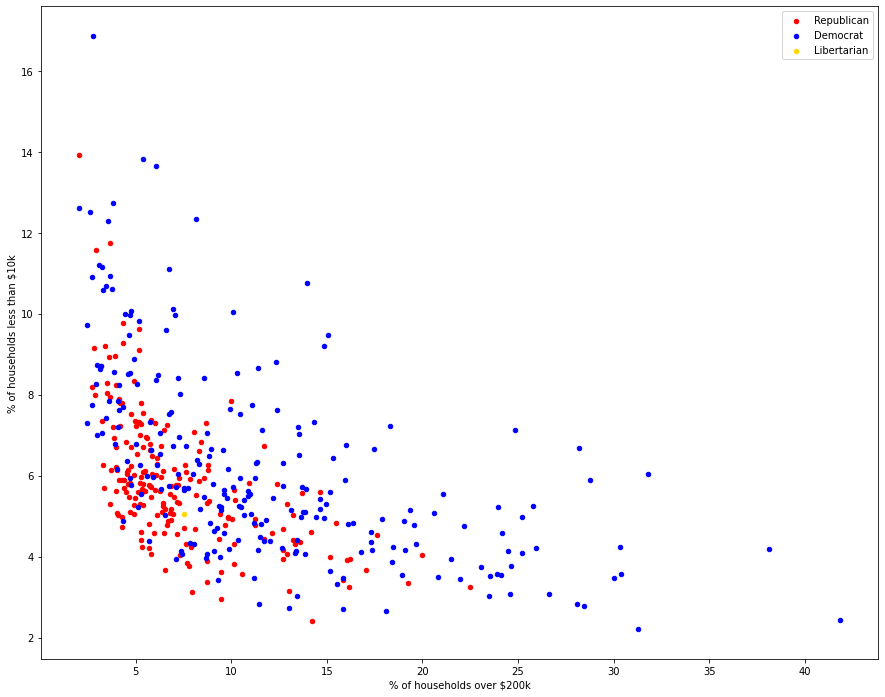

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of households less than $10k', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='gold',label='Libertarian', ax=ax)


plt.legend()
plt.show()

**Analysis of vehicle ownership based on congressional district party:**

For our second visual we continued with the scatterplot but this time looked at the percentage owning no vehicles(y axis) and percentage owning 3+ vehicles(x axis). The plot is still colored by political affilitation.  We can see by looking at the visual that Democrats vehicle ownership percentages are higher when it comes to owning no vehicles compared to Republicans being heavier on owning 3+ vehicles.  This further supports our hypothesis that Democrats would own less vehicles because they are environmentally conscious. 

In [ ]:
merged_df.to_csv("congressional_district_with_parties.csv")

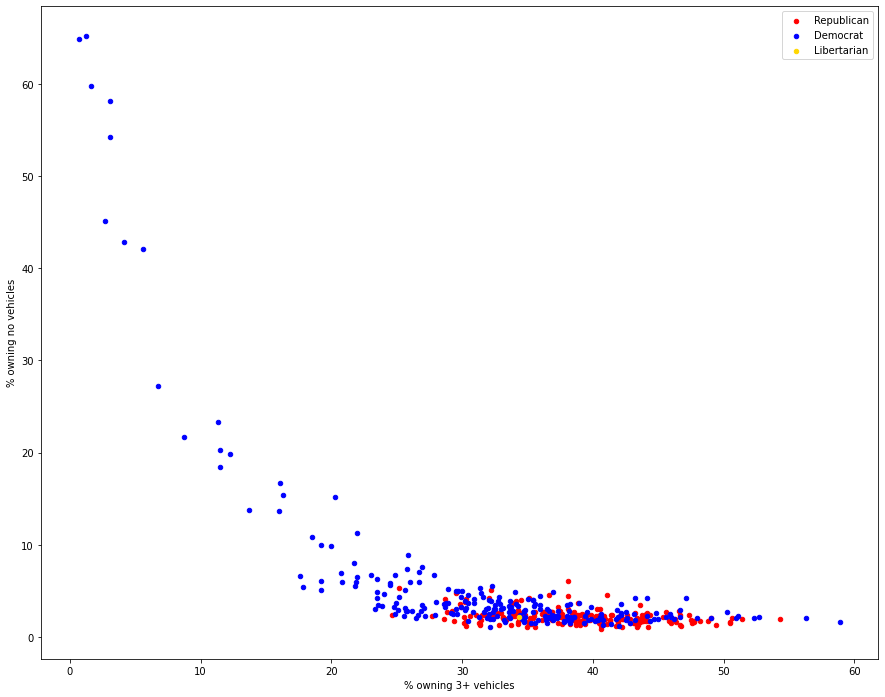

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 3+ vehicles', y='% owning no vehicles', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 3+ vehicles', y='% owning no vehicles',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 3+ vehicles', y='% owning no vehicles',c='gold',label='Libertarian', ax=ax)



plt.legend()
plt.show()

On this scatterplot we decided to also include the percentage owning no vehicles(y axis) and percentage owning 1 vehicle(x axis) to investigate any differences in less extreme conditions. But again, Republicans had a low percentage when it comes to owning no vehicles or even 1 vehicle. 

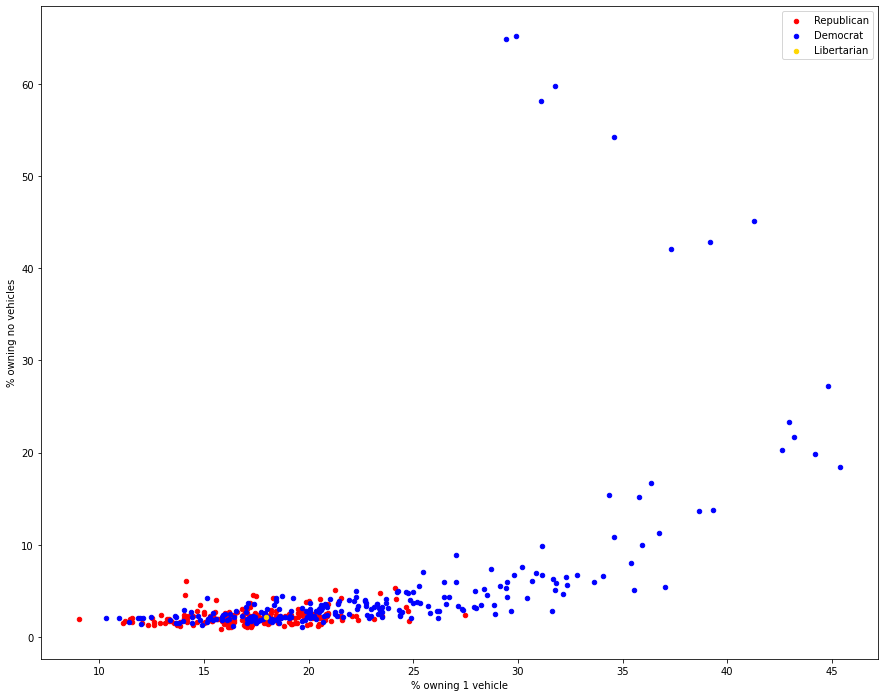

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 1 vehicle', y='% owning no vehicles', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 1 vehicle', y='% owning no vehicles',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 1 vehicle', y='% owning no vehicles',c='gold',label='Libertarian', ax=ax)


plt.legend()
plt.show()

On this scatterplot were looking at percentage that own 1 vehicle (y axis) and owning 2 vehicles (x axis), we notice that both parties seem to be fairly similar when it comes to owning 2 vehicles. However, Democrats tend to lean more to owning less vehicles then Republicans tend to.

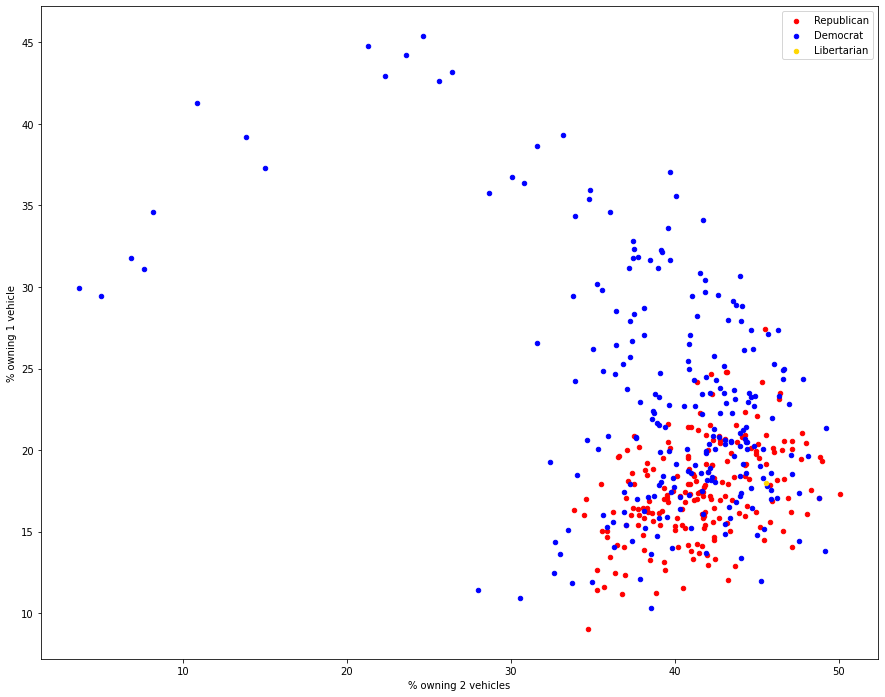

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 2 vehicles', y='% owning 1 vehicle', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 2 vehicles', y='% owning 1 vehicle',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 2 vehicles', y='% owning 1 vehicle',c='gold',label='Libertarian', ax=ax)



plt.legend()
plt.show()

On this final visual we looked at percentage of owning 2 vehicles(y axis) and percentage owning 3 or more vehicles(x axis) we found that Democrats had more variety across the graph while Republicans are in the high percentages for both 2 vehicles and 3 or more vehicles.  

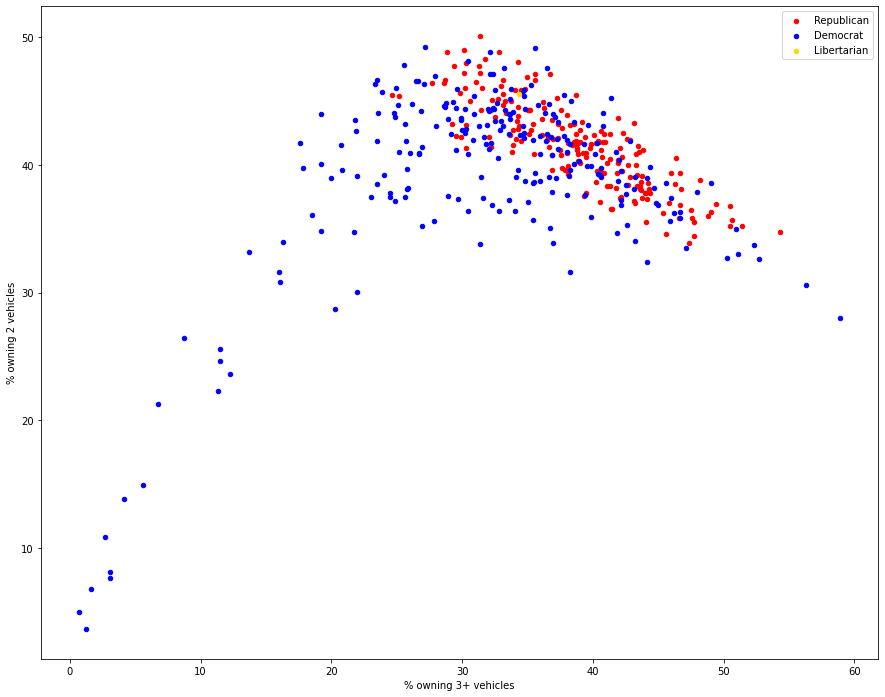

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 3+ vehicles', y='% owning 2 vehicles', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 3+ vehicles', y='% owning 2 vehicles',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 3+ vehicles', y='% owning 2 vehicles',c='gold',label='Libertarian', ax=ax)



plt.legend()
plt.show()

**Conclusion:**

Ultimately, these graphs support our hypothesis that Republicans will own more vehicles than Democrats.

Also, Republican congressional districts were more condensed while Democratic responses were more spread out with their responses.  

*Note:* 

Based on the income analysis, Democratic districts generally have higher incomes than Republican districts. This could lead us to believe that Democratic individuals would also be likely to own more vehicles than Republicans. A possible confounder could be recreational vehicles including ATVs, motorcycles, motorhomes.